# Imports

In [1]:
import numpy as np
import torch
import os
from matplotlib import pyplot as plt

from utils.image_helpers import plot_image_grid, get_images
from simulation.Simulation import Simulation
from utils.configuration_parser.gridsearch_configuration import get_gridsearch_configuration
from models.model_creation import create_model_from_parameter_combination
from fitting.Fitter import create_fitter_from_configuration
from utils.pickle_utils import save_gridsearch_result

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '3'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Load Image

In [2]:
number_of_images_used = 10

Number of Images: 10000 in data/imagenet_v2_top_images


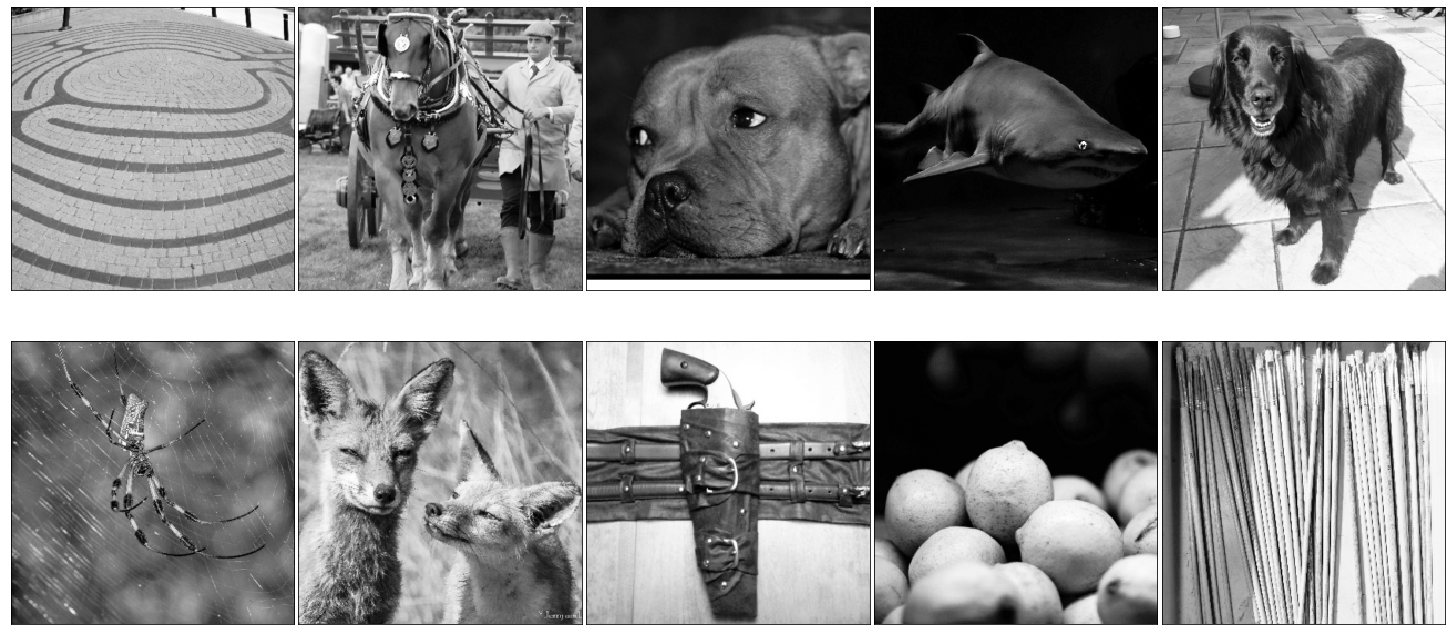

In [3]:
original_images = get_images('data/imagenet_v2_top_images', max_amount=number_of_images_used)
plot = plot_image_grid(original_images, ncols = 5)

# Gibbs Simulation

In [4]:
image_dimensions = original_images[0].shape
print(image_dimensions)
cropped_size = (100, 100)

(256, 256)


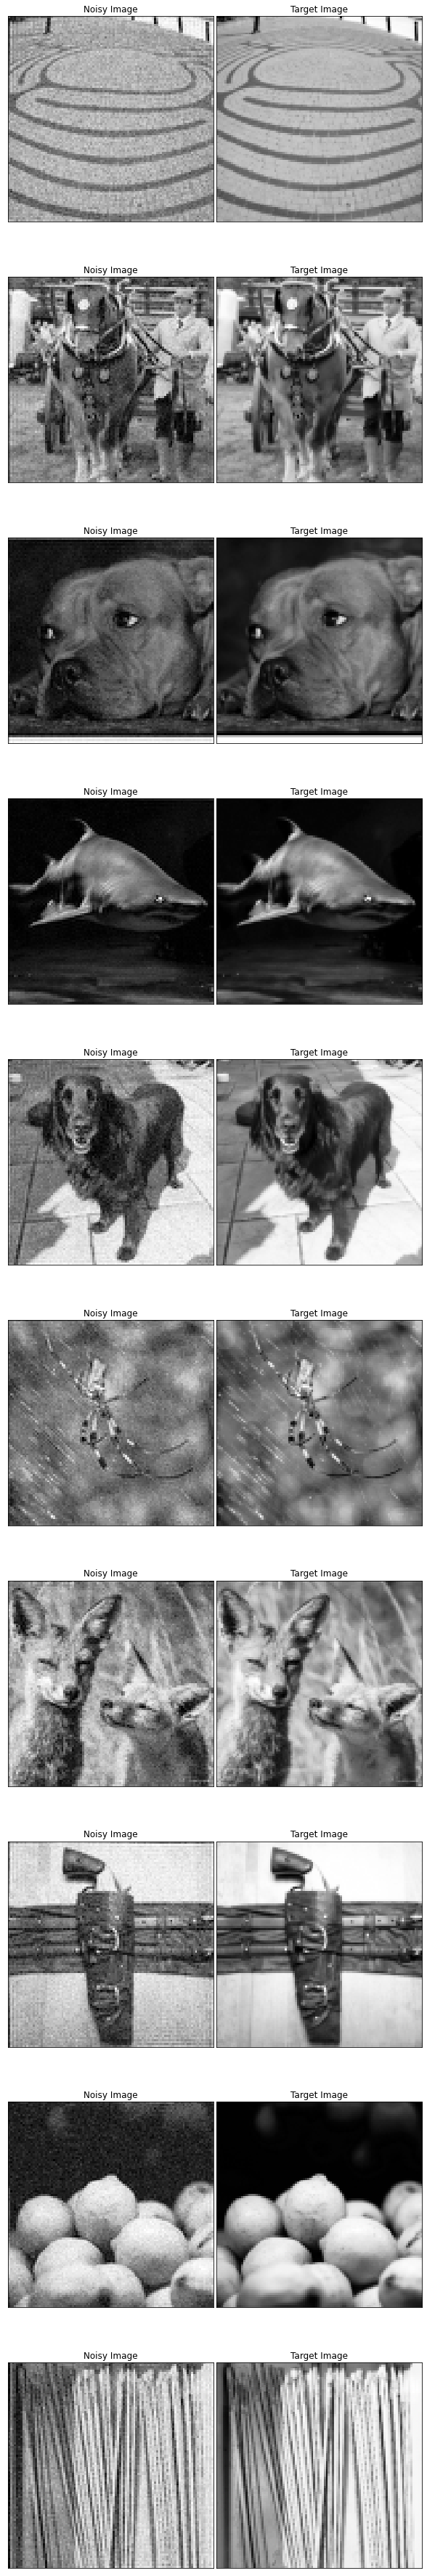

In [5]:
simulation = Simulation(input_size=image_dimensions, cropped_size=cropped_size, snr_range=(4,4))
noisy_images, target_images = simulation.simulate_list_of_images(original_images)

all_images = [x for row in zip(noisy_images, target_images) for x in row]
titles = ['Noisy Image', 'Target Image'] * len(noisy_images)
plot_image_grid(all_images, titles, ncols=2)
plt.show()

# Configuration

In [6]:
gridsearch_configuration = get_gridsearch_configuration()

gridsearch_configuration.model_types = ['deep']
gridsearch_configuration.input_shapes = [[4,4], [4,8], [8,8], [8,16], [16,16]]
gridsearch_configuration.numbers_of_hidden_channels = [32, 64, 128]
gridsearch_configuration.numbers_of_layers = [5, 8, 10, 13]
gridsearch_configuration.number_of_runs = 10
gridsearch_configuration.image_dimensions = list(cropped_size) + [1]

gridsearch_configuration.convergence_check_length = None
gridsearch_configuration.number_of_iterations = 1000
gridsearch_configuration.log_frequency = 100
gridsearch_configuration.save_losses = False
gridsearch_configuration.find_best = False

print(gridsearch_configuration)

image_dimensions: [100, 100, 1]  
result_path: data/results/2020-11-30-09:24-gridsearch.pkl  
model_types: ['deep']  
input_shapes: [[4, 4], [4, 8], [8, 8], [8, 16], [16, 16]]  
numbers_of_layers: [5, 8, 10, 13]  
numbers_of_hidden_channels: [32, 64, 128]  
number_of_runs: 10  
number_of_iterations: 1000  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



In [7]:
parameter_combinations = gridsearch_configuration.generate_parameter_combinations()
# for parameters in parameter_combinations:
    # print(parameters) 

# Fit all parameter combinations and save results

In [8]:
fitter = create_fitter_from_configuration(gridsearch_configuration)

In [ ]:
 for image_index, (noisy_image, target_image) in enumerate(zip(noisy_images, target_images)):
    for parameter_index, parameter_combination in enumerate(parameter_combinations):
        print(f'Image: {image_index+1}/{len(noisy_images)}, Parameter Combination: {parameter_index+1}/{len(parameter_combinations)}')
        print('+++' + str(parameter_combination) + '+++')
        model = create_model_from_parameter_combination(parameter_combination, noisy_image.shape)
        fitter(model, noisy_image, target_image)
        result = fitter.get_result()
        save_gridsearch_result(result, gridsearch_configuration.result_path)
        print('')

Image: 1/10, Parameter Combination: 1/600
+++('deep', [4, 4], 5, 32)+++
Step: 01000, Loss: 0.003891, Target Loss: 0.002589
Image: 1/10, Parameter Combination: 2/600
+++('deep', [4, 4], 5, 64)+++
Step: 01000, Loss: 0.004284, Target Loss: 0.002905
Image: 1/10, Parameter Combination: 3/600
+++('deep', [4, 4], 5, 128)+++
Step: 01000, Loss: 0.007332, Target Loss: 0.005409
Image: 1/10, Parameter Combination: 4/600
+++('deep', [4, 4], 8, 32)+++
Step: 01000, Loss: 0.003208, Target Loss: 0.002067
Image: 1/10, Parameter Combination: 5/600
+++('deep', [4, 4], 8, 64)+++
Step: 01000, Loss: 0.003137, Target Loss: 0.002008
Image: 1/10, Parameter Combination: 6/600
+++('deep', [4, 4], 8, 128)+++
Step: 01000, Loss: 0.005598, Target Loss: 0.003743
Image: 1/10, Parameter Combination: 7/600
+++('deep', [4, 4], 10, 32)+++
Step: 01000, Loss: 0.002306, Target Loss: 0.001655
Image: 1/10, Parameter Combination: 8/600
+++('deep', [4, 4], 10, 64)+++
Step: 01000, Loss: 0.003573, Target Loss: 0.002531
Image: 1/10,

Step: 01000, Loss: 0.003151, Target Loss: 0.002027
Image: 1/10, Parameter Combination: 67/600
+++('deep', [4, 4], 10, 32)+++
Step: 01000, Loss: 0.003560, Target Loss: 0.002206
Image: 1/10, Parameter Combination: 68/600
+++('deep', [4, 4], 10, 64)+++
Step: 01000, Loss: 0.002412, Target Loss: 0.001547
Image: 1/10, Parameter Combination: 69/600
+++('deep', [4, 4], 10, 128)+++
Step: 01000, Loss: 0.006892, Target Loss: 0.004988
Image: 1/10, Parameter Combination: 70/600
+++('deep', [4, 4], 13, 32)+++
Step: 01000, Loss: 0.003648, Target Loss: 0.002283
Image: 1/10, Parameter Combination: 71/600
+++('deep', [4, 4], 13, 64)+++
Step: 01000, Loss: 0.005162, Target Loss: 0.003856
Image: 1/10, Parameter Combination: 72/600
+++('deep', [4, 4], 13, 128)+++
Step: 01000, Loss: 0.004348, Target Loss: 0.002856
Image: 1/10, Parameter Combination: 73/600
+++('deep', [4, 8], 5, 32)+++
Step: 01000, Loss: 0.004404, Target Loss: 0.003090
Image: 1/10, Parameter Combination: 74/600
+++('deep', [4, 8], 5, 64)+++


Step: 01000, Loss: 0.002068, Target Loss: 0.001456
Image: 1/10, Parameter Combination: 132/600
+++('deep', [4, 4], 13, 128)+++
Step: 01000, Loss: 0.007694, Target Loss: 0.005726
Image: 1/10, Parameter Combination: 133/600
+++('deep', [4, 8], 5, 32)+++
Step: 01000, Loss: 0.003369, Target Loss: 0.002290
Image: 1/10, Parameter Combination: 134/600
+++('deep', [4, 8], 5, 64)+++
Step: 01000, Loss: 0.003855, Target Loss: 0.002843
Image: 1/10, Parameter Combination: 135/600
+++('deep', [4, 8], 5, 128)+++
Step: 01000, Loss: 0.004296, Target Loss: 0.002950
Image: 1/10, Parameter Combination: 136/600
+++('deep', [4, 8], 8, 32)+++
Step: 01000, Loss: 0.003011, Target Loss: 0.002143
Image: 1/10, Parameter Combination: 137/600
+++('deep', [4, 8], 8, 64)+++
Step: 01000, Loss: 0.002388, Target Loss: 0.001658
Image: 1/10, Parameter Combination: 138/600
+++('deep', [4, 8], 8, 128)+++
Step: 01000, Loss: 0.004508, Target Loss: 0.003072
Image: 1/10, Parameter Combination: 139/600
+++('deep', [4, 8], 10, 32

Step: 01000, Loss: 0.002900, Target Loss: 0.002091
Image: 1/10, Parameter Combination: 197/600
+++('deep', [4, 8], 8, 64)+++
Step: 01000, Loss: 0.002369, Target Loss: 0.001567
Image: 1/10, Parameter Combination: 198/600
+++('deep', [4, 8], 8, 128)+++
Step: 01000, Loss: 0.004244, Target Loss: 0.002768
Image: 1/10, Parameter Combination: 199/600
+++('deep', [4, 8], 10, 32)+++
Step: 01000, Loss: 0.003452, Target Loss: 0.002408
Image: 1/10, Parameter Combination: 200/600
+++('deep', [4, 8], 10, 64)+++
Step: 01000, Loss: 0.002851, Target Loss: 0.001858
Image: 1/10, Parameter Combination: 201/600
+++('deep', [4, 8], 10, 128)+++
Step: 01000, Loss: 0.007015, Target Loss: 0.005130
Image: 1/10, Parameter Combination: 202/600
+++('deep', [4, 8], 13, 32)+++
Step: 01000, Loss: 0.002784, Target Loss: 0.001886
Image: 1/10, Parameter Combination: 203/600
+++('deep', [4, 8], 13, 64)+++
Step: 01000, Loss: 0.003158, Target Loss: 0.001967
Image: 1/10, Parameter Combination: 204/600
+++('deep', [4, 8], 13,

Step: 01000, Loss: 0.004214, Target Loss: 0.003072
Image: 1/10, Parameter Combination: 262/600
+++('deep', [4, 8], 13, 32)+++
Step: 01000, Loss: 0.002095, Target Loss: 0.001646
Image: 1/10, Parameter Combination: 263/600
+++('deep', [4, 8], 13, 64)+++
Step: 01000, Loss: 0.004978, Target Loss: 0.003430
Image: 1/10, Parameter Combination: 264/600
+++('deep', [4, 8], 13, 128)+++
Step: 01000, Loss: 0.008821, Target Loss: 0.006796
Image: 1/10, Parameter Combination: 265/600
+++('deep', [8, 8], 5, 32)+++
Step: 01000, Loss: 0.002377, Target Loss: 0.001631
Image: 1/10, Parameter Combination: 266/600
+++('deep', [8, 8], 5, 64)+++
Step: 01000, Loss: 0.002064, Target Loss: 0.001462
Image: 1/10, Parameter Combination: 267/600
+++('deep', [8, 8], 5, 128)+++
Step: 01000, Loss: 0.004584, Target Loss: 0.003065
Image: 1/10, Parameter Combination: 268/600
+++('deep', [8, 8], 8, 32)+++
Step: 01000, Loss: 0.002931, Target Loss: 0.002028
Image: 1/10, Parameter Combination: 269/600
+++('deep', [8, 8], 8, 64

Step: 01000, Loss: 0.002134, Target Loss: 0.001481
Image: 1/10, Parameter Combination: 327/600
+++('deep', [8, 8], 5, 128)+++
Step: 01000, Loss: 0.003844, Target Loss: 0.002633
Image: 1/10, Parameter Combination: 328/600
+++('deep', [8, 8], 8, 32)+++
Step: 01000, Loss: 0.001835, Target Loss: 0.001531
Image: 1/10, Parameter Combination: 329/600
+++('deep', [8, 8], 8, 64)+++
Step: 01000, Loss: 0.002129, Target Loss: 0.001454
Image: 1/10, Parameter Combination: 330/600
+++('deep', [8, 8], 8, 128)+++
Step: 01000, Loss: 0.003076, Target Loss: 0.002049
Image: 1/10, Parameter Combination: 331/600
+++('deep', [8, 8], 10, 32)+++
Step: 01000, Loss: 0.002812, Target Loss: 0.001846
Image: 1/10, Parameter Combination: 332/600
+++('deep', [8, 8], 10, 64)+++
Step: 01000, Loss: 0.001783, Target Loss: 0.001524
Image: 1/10, Parameter Combination: 333/600
+++('deep', [8, 8], 10, 128)+++
Step: 01000, Loss: 0.209234, Target Loss: 0.207966
Image: 1/10, Parameter Combination: 334/600
+++('deep', [8, 8], 13, 

Step: 01000, Loss: 0.002652, Target Loss: 0.001875
Image: 1/10, Parameter Combination: 392/600
+++('deep', [8, 8], 10, 64)+++
Step: 01000, Loss: 0.002047, Target Loss: 0.001480
Image: 1/10, Parameter Combination: 393/600
+++('deep', [8, 8], 10, 128)+++
Step: 01000, Loss: 0.002208, Target Loss: 0.001569
Image: 1/10, Parameter Combination: 394/600
+++('deep', [8, 8], 13, 32)+++
Step: 01000, Loss: 0.002021, Target Loss: 0.001515
Image: 1/10, Parameter Combination: 395/600
+++('deep', [8, 8], 13, 64)+++
Step: 01000, Loss: 0.003046, Target Loss: 0.002560
Image: 1/10, Parameter Combination: 396/600
+++('deep', [8, 8], 13, 128)+++
Step: 01000, Loss: 0.002052, Target Loss: 0.001557
Image: 1/10, Parameter Combination: 397/600
+++('deep', [8, 16], 5, 32)+++
Step: 01000, Loss: 0.002288, Target Loss: 0.001778
Image: 1/10, Parameter Combination: 398/600
+++('deep', [8, 16], 5, 64)+++
Step: 01000, Loss: 0.002238, Target Loss: 0.001754
Image: 1/10, Parameter Combination: 399/600
+++('deep', [8, 16], 

Step: 01000, Loss: 0.003767, Target Loss: 0.002650
Image: 1/10, Parameter Combination: 457/600
+++('deep', [8, 16], 5, 32)+++
Step: 01000, Loss: 0.002392, Target Loss: 0.001955
Image: 1/10, Parameter Combination: 458/600
+++('deep', [8, 16], 5, 64)+++
Step: 01000, Loss: 0.001956, Target Loss: 0.001740
Image: 1/10, Parameter Combination: 459/600
+++('deep', [8, 16], 5, 128)+++
Step: 01000, Loss: 0.005838, Target Loss: 0.004263
Image: 1/10, Parameter Combination: 460/600
+++('deep', [8, 16], 8, 32)+++
Step: 01000, Loss: 0.001973, Target Loss: 0.001682
Image: 1/10, Parameter Combination: 461/600
+++('deep', [8, 16], 8, 64)+++
Step: 01000, Loss: 0.001817, Target Loss: 0.001580
Image: 1/10, Parameter Combination: 462/600
+++('deep', [8, 16], 8, 128)+++
Step: 01000, Loss: 0.001743, Target Loss: 0.001596
Image: 1/10, Parameter Combination: 463/600
+++('deep', [8, 16], 10, 32)+++
Step: 01000, Loss: 0.001669, Target Loss: 0.001543
Image: 1/10, Parameter Combination: 464/600
+++('deep', [8, 16],

Step: 01000, Loss: 0.001935, Target Loss: 0.001835
Image: 1/10, Parameter Combination: 522/600
+++('deep', [8, 16], 8, 128)+++
Step: 01000, Loss: 0.001879, Target Loss: 0.001665
Image: 1/10, Parameter Combination: 523/600
+++('deep', [8, 16], 10, 32)+++
Step: 01000, Loss: 0.001971, Target Loss: 0.001577
Image: 1/10, Parameter Combination: 524/600
+++('deep', [8, 16], 10, 64)+++
Step: 01000, Loss: 0.001940, Target Loss: 0.001831
Image: 1/10, Parameter Combination: 525/600
+++('deep', [8, 16], 10, 128)+++
Step: 01000, Loss: 0.007009, Target Loss: 0.005267
Image: 1/10, Parameter Combination: 526/600
+++('deep', [8, 16], 13, 32)+++
Step: 01000, Loss: 0.002349, Target Loss: 0.001848
Image: 1/10, Parameter Combination: 527/600
+++('deep', [8, 16], 13, 64)+++
Step: 01000, Loss: 0.002065, Target Loss: 0.001717
Image: 1/10, Parameter Combination: 528/600
+++('deep', [8, 16], 13, 128)+++
Step: 01000, Loss: 0.001675, Target Loss: 0.001568
Image: 1/10, Parameter Combination: 529/600
+++('deep', [1

Step: 01000, Loss: 0.002544, Target Loss: 0.001931
Image: 1/10, Parameter Combination: 587/600
+++('deep', [8, 16], 13, 64)+++
Step: 01000, Loss: 0.001716, Target Loss: 0.001624
Image: 1/10, Parameter Combination: 588/600
+++('deep', [8, 16], 13, 128)+++
Step: 01000, Loss: 0.001586, Target Loss: 0.001602
Image: 1/10, Parameter Combination: 589/600
+++('deep', [16, 16], 5, 32)+++
Step: 01000, Loss: 0.002033, Target Loss: 0.002079
Image: 1/10, Parameter Combination: 590/600
+++('deep', [16, 16], 5, 64)+++
Step: 01000, Loss: 0.001457, Target Loss: 0.001601
Image: 1/10, Parameter Combination: 591/600
+++('deep', [16, 16], 5, 128)+++
Step: 01000, Loss: 0.001769, Target Loss: 0.001542
Image: 1/10, Parameter Combination: 592/600
+++('deep', [16, 16], 8, 32)+++
Step: 01000, Loss: 0.001785, Target Loss: 0.001722
Image: 1/10, Parameter Combination: 593/600
+++('deep', [16, 16], 8, 64)+++
Step: 01000, Loss: 0.002110, Target Loss: 0.002030
Image: 1/10, Parameter Combination: 594/600
+++('deep', [1

Step: 01000, Loss: 0.001990, Target Loss: 0.003404
Image: 2/10, Parameter Combination: 52/600
+++('deep', [16, 16], 8, 32)+++
Step: 01000, Loss: 0.003919, Target Loss: 0.003855
Image: 2/10, Parameter Combination: 53/600
+++('deep', [16, 16], 8, 64)+++
Step: 01000, Loss: 0.002117, Target Loss: 0.003297
Image: 2/10, Parameter Combination: 54/600
+++('deep', [16, 16], 8, 128)+++
Step: 01000, Loss: 0.002922, Target Loss: 0.003390
Image: 2/10, Parameter Combination: 55/600
+++('deep', [16, 16], 10, 32)+++
Step: 01000, Loss: 0.003548, Target Loss: 0.003918
Image: 2/10, Parameter Combination: 56/600
+++('deep', [16, 16], 10, 64)+++
Step: 01000, Loss: 0.001891, Target Loss: 0.003061
Image: 2/10, Parameter Combination: 57/600
+++('deep', [16, 16], 10, 128)+++
Step: 01000, Loss: 0.004806, Target Loss: 0.004426
Image: 2/10, Parameter Combination: 58/600
+++('deep', [16, 16], 13, 32)+++
Step: 01000, Loss: 0.003681, Target Loss: 0.004192
Image: 2/10, Parameter Combination: 59/600
+++('deep', [16, 1

Step: 01000, Loss: 0.003426, Target Loss: 0.003821
Image: 2/10, Parameter Combination: 117/600
+++('deep', [16, 16], 10, 128)+++
Step: 01000, Loss: 0.003620, Target Loss: 0.003709
Image: 2/10, Parameter Combination: 118/600
+++('deep', [16, 16], 13, 32)+++
Step: 01000, Loss: 0.003999, Target Loss: 0.004289
Image: 2/10, Parameter Combination: 119/600
+++('deep', [16, 16], 13, 64)+++
Step: 01000, Loss: 0.002430, Target Loss: 0.003624
Image: 2/10, Parameter Combination: 120/600
+++('deep', [16, 16], 13, 128)+++
Step: 01000, Loss: 0.003734, Target Loss: 0.003918
Image: 2/10, Parameter Combination: 121/600
+++('deep', [4, 4], 5, 32)+++
Step: 01000, Loss: 0.010584, Target Loss: 0.008315
Image: 2/10, Parameter Combination: 122/600
+++('deep', [4, 4], 5, 64)+++
Step: 01000, Loss: 0.008519, Target Loss: 0.006633
Image: 2/10, Parameter Combination: 123/600
+++('deep', [4, 4], 5, 128)+++
Step: 01000, Loss: 0.009596, Target Loss: 0.007386
Image: 2/10, Parameter Combination: 124/600
+++('deep', [4,

Step: 01000, Loss: 0.007939, Target Loss: 0.006164
Image: 2/10, Parameter Combination: 182/600
+++('deep', [4, 4], 5, 64)+++
Step: 01000, Loss: 0.007577, Target Loss: 0.005713
Image: 2/10, Parameter Combination: 183/600
+++('deep', [4, 4], 5, 128)+++
Step: 01000, Loss: 0.011719, Target Loss: 0.009256
Image: 2/10, Parameter Combination: 184/600
+++('deep', [4, 4], 8, 32)+++
Step: 01000, Loss: 0.006354, Target Loss: 0.004835
Image: 2/10, Parameter Combination: 185/600
+++('deep', [4, 4], 8, 64)+++
Step: 01000, Loss: 0.005339, Target Loss: 0.004223
Image: 2/10, Parameter Combination: 186/600
+++('deep', [4, 4], 8, 128)+++
Step: 01000, Loss: 0.007803, Target Loss: 0.006657
Image: 2/10, Parameter Combination: 187/600
+++('deep', [4, 4], 10, 32)+++
Step: 01000, Loss: 0.007217, Target Loss: 0.005857
Image: 2/10, Parameter Combination: 188/600
+++('deep', [4, 4], 10, 64)+++
Step: 01000, Loss: 0.005046, Target Loss: 0.004356
Image: 2/10, Parameter Combination: 189/600
+++('deep', [4, 4], 10, 12

Step: 01000, Loss: 0.006509, Target Loss: 0.005458
Image: 2/10, Parameter Combination: 247/600
+++('deep', [4, 4], 10, 32)+++
Step: 01000, Loss: 0.009874, Target Loss: 0.007908
Image: 2/10, Parameter Combination: 248/600
+++('deep', [4, 4], 10, 64)+++
Step: 01000, Loss: 0.005659, Target Loss: 0.004910
Image: 2/10, Parameter Combination: 249/600
+++('deep', [4, 4], 10, 128)+++
Step: 01000, Loss: 0.006521, Target Loss: 0.005368
Image: 2/10, Parameter Combination: 250/600
+++('deep', [4, 4], 13, 32)+++
Step: 01000, Loss: 0.006514, Target Loss: 0.005352
Image: 2/10, Parameter Combination: 251/600
+++('deep', [4, 4], 13, 64)+++
Step: 01000, Loss: 0.005439, Target Loss: 0.004955
Image: 2/10, Parameter Combination: 252/600
+++('deep', [4, 4], 13, 128)+++
Step: 01000, Loss: 0.006305, Target Loss: 0.005268
Image: 2/10, Parameter Combination: 253/600
+++('deep', [4, 8], 5, 32)+++
Step: 01000, Loss: 0.007753, Target Loss: 0.006125
Image: 2/10, Parameter Combination: 254/600
+++('deep', [4, 8], 5,

Step: 01000, Loss: 0.005937, Target Loss: 0.004792
Image: 2/10, Parameter Combination: 312/600
+++('deep', [4, 4], 13, 128)+++
Step: 01000, Loss: 0.008119, Target Loss: 0.006511
Image: 2/10, Parameter Combination: 313/600
+++('deep', [4, 8], 5, 32)+++
Step: 01000, Loss: 0.006366, Target Loss: 0.005144
Image: 2/10, Parameter Combination: 314/600
+++('deep', [4, 8], 5, 64)+++
Step: 01000, Loss: 0.006288, Target Loss: 0.005264
Image: 2/10, Parameter Combination: 315/600
+++('deep', [4, 8], 5, 128)+++
Step: 01000, Loss: 0.006702, Target Loss: 0.005357
Image: 2/10, Parameter Combination: 316/600
+++('deep', [4, 8], 8, 32)+++
Step: 01000, Loss: 0.006063, Target Loss: 0.005163
Image: 2/10, Parameter Combination: 317/600
+++('deep', [4, 8], 8, 64)+++
Step: 01000, Loss: 0.005399, Target Loss: 0.004514
Image: 2/10, Parameter Combination: 318/600
+++('deep', [4, 8], 8, 128)+++
Step: 01000, Loss: 0.007568, Target Loss: 0.005925
Image: 2/10, Parameter Combination: 319/600
+++('deep', [4, 8], 10, 32

Step: 01000, Loss: 0.006527, Target Loss: 0.005563
Image: 2/10, Parameter Combination: 377/600
+++('deep', [4, 8], 8, 64)+++
Step: 01000, Loss: 0.004864, Target Loss: 0.004581
Image: 2/10, Parameter Combination: 378/600
+++('deep', [4, 8], 8, 128)+++
Step: 01000, Loss: 0.008609, Target Loss: 0.007213
Image: 2/10, Parameter Combination: 379/600
+++('deep', [4, 8], 10, 32)+++
Step: 01000, Loss: 0.006585, Target Loss: 0.005742
Image: 2/10, Parameter Combination: 380/600
+++('deep', [4, 8], 10, 64)+++
Step: 01000, Loss: 0.006285, Target Loss: 0.005355
Image: 2/10, Parameter Combination: 381/600
+++('deep', [4, 8], 10, 128)+++
Step: 01000, Loss: 0.005489, Target Loss: 0.004825
Image: 2/10, Parameter Combination: 382/600
+++('deep', [4, 8], 13, 32)+++
Step: 01000, Loss: 0.005751, Target Loss: 0.004932
Image: 2/10, Parameter Combination: 383/600
+++('deep', [4, 8], 13, 64)+++
Step: 01000, Loss: 0.004677, Target Loss: 0.004220
Image: 2/10, Parameter Combination: 384/600
+++('deep', [4, 8], 13,

Step: 01000, Loss: 0.006555, Target Loss: 0.005002
Image: 2/10, Parameter Combination: 442/600
+++('deep', [4, 8], 13, 32)+++
Step: 01000, Loss: 0.007244, Target Loss: 0.005901
Image: 2/10, Parameter Combination: 443/600
+++('deep', [4, 8], 13, 64)+++
Step: 01000, Loss: 0.004927, Target Loss: 0.004274
Image: 2/10, Parameter Combination: 444/600
+++('deep', [4, 8], 13, 128)+++
Step: 01000, Loss: 0.006194, Target Loss: 0.005226
Image: 2/10, Parameter Combination: 445/600
+++('deep', [8, 8], 5, 32)+++
Step: 01000, Loss: 0.004631, Target Loss: 0.004202
Image: 2/10, Parameter Combination: 446/600
+++('deep', [8, 8], 5, 64)+++
Step: 01000, Loss: 0.003734, Target Loss: 0.003554
Image: 2/10, Parameter Combination: 447/600
+++('deep', [8, 8], 5, 128)+++
Step: 01000, Loss: 0.006139, Target Loss: 0.004919
Image: 2/10, Parameter Combination: 448/600
+++('deep', [8, 8], 8, 32)+++
Step: 01000, Loss: 0.004403, Target Loss: 0.004025
Image: 2/10, Parameter Combination: 449/600
+++('deep', [8, 8], 8, 64

Step: 01000, Loss: 0.004680, Target Loss: 0.004402
Image: 2/10, Parameter Combination: 507/600
+++('deep', [8, 8], 5, 128)+++
Step: 01000, Loss: 0.003713, Target Loss: 0.003613
Image: 2/10, Parameter Combination: 508/600
+++('deep', [8, 8], 8, 32)+++
Step: 01000, Loss: 0.004682, Target Loss: 0.004227
Image: 2/10, Parameter Combination: 509/600
+++('deep', [8, 8], 8, 64)+++
Step: 01000, Loss: 0.003964, Target Loss: 0.004181
Image: 2/10, Parameter Combination: 510/600
+++('deep', [8, 8], 8, 128)+++
Step: 01000, Loss: 0.003377, Target Loss: 0.003515
Image: 2/10, Parameter Combination: 511/600
+++('deep', [8, 8], 10, 32)+++
Step: 01000, Loss: 0.005167, Target Loss: 0.004509
Image: 2/10, Parameter Combination: 512/600
+++('deep', [8, 8], 10, 64)+++
Step: 01000, Loss: 0.004879, Target Loss: 0.004588
Image: 2/10, Parameter Combination: 513/600
+++('deep', [8, 8], 10, 128)+++
Step: 01000, Loss: 0.005224, Target Loss: 0.004643
Image: 2/10, Parameter Combination: 514/600
+++('deep', [8, 8], 13, 